<a href="https://colab.research.google.com/github/rodolfoarruda/MachineLearning/blob/main/Pratica_ProcImg_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICMC - Instituto de Ciências Matemáticas e de Computação
## SCC5830 - Image Processing (2021)

# Rodolfo Augusto Da Silva Arruda - 6381848

### **Título:** Segmentação de lavoura de feijão, com relação à área coberta por vegetação, utilizando imagens coletadas via dispositivo de baixo custo e baixa altitude.

### **1- Introdução**

##### Segundo **Ponti et al (2016)** a obtenção de imagens via satélites é custosa e pode ser um limitador para estudar aplicações no campo da agricultura de precisão. Como alternativa, o pesquisador afirma que uma solução viável e de baixo custo é a utilização de sensoriamento remoto de baixa altitude, tal como o uso UAVs (veículos aéreos não tripulados) ou dirigíveis para coletar imagens, visando, por exemplo, estimar a produtividade, contar ervas daninhas ou o número de plantas.

##### No referido artigo, os autores utilizaram para os experimentos imagens deste tipo (baixo custo e baixa altitude) para estimar a área plantada de lavouras, as quaisi constituíram dois datasets. O primeiro sobre a cultura de feijões, coletado via um sistema que combina partes de um balão de hélio e uma pipa (Skyhook Helikite) e o segundo coletado via um UAV para coletar dados de cana de açúcar e eucalipto.

##### A identificação dos pixels das imagens com relação às duas classes (área com vegetação ou sem vegetação) foi obtida com auxílio de três especialistas da área de agronomia. A votação entre a opinião dos três constituiu a verdade absoluta com relação ao rótulo.


### **2- Material**

##### Para o propósito deste trabalho será utilizado o conjunto de dados sobre a lavoura de feijão, que é composto por 40 imagens coletadas em dois diferentes campos, sendo 18 de uma cultura mais produtiva (mais área com vegetação) e as 22 restantes de um campo menos produtivas, onde é maior a presença de plantas, ervas daninhas e solo. Todas as imagens foram coletadas a uma altura de 50 metros de altura, com o uso de um sistema dirigível e uma câmera de 10MP, com 24-bit RGB.

##### As imagens obtidas foram cortadas em quadrados de dimensão 512 × 512 pixels e armazenadas em formato PNG. O conjunto de dados final consiste em 29.556 exemplos da classe positiva (72,1% dos pixels) e 11.404 exemplos da classe negativa (27,9% dos pixels).



#### **2.1 - Setup**

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Básicos
import numpy as np
import matplotlib.pyplot as plt

# Ler e salvar imagens
from skimage.io import imread_collection
from skimage.io import imsave
from skimage.io import imshow
import random

# Manipular imagem
import cv2

# Avaliação do modelo
from sklearn.metrics import f1_score

# Suprimir notação científica do Numpy
np.set_printoptions(suppress=True) 

# Deep Learning
%env SM_FRAMEWORK=tf.keras
import mahotas as mt
import keras 
import tensorflow as tf
keras.__version__
import segmentation_models as sm
keras.backend.set_image_data_format('channels_last')
import os

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import tensorflow as tf
import segmentation_models as sm
import cv2


env: SM_FRAMEWORK=tf.keras


#### **2.2 - Preparação dos dados**

#### **Partição do conjunto de dados** 
#### **Desenvolvimento:** 60% -- 24 imagens 
#### **Teste:** 20% -- 8 imagens          
#### **Validação:** 20% -- 8 imagens

In [ ]:
np.random.seed(10)

list  = np.arange(1,41)
dev   = np.random.choice(list, 24, replace=False)
dev_compl = np.setdiff1d(list, dev)
test  = np.random.choice(dev_compl, 8, replace=False)
valid = np.setdiff1d(dev_compl, test)

In [ ]:
print("Train:",dev);print("Test:",test);print("Valid:",valid)

Train: [ 3 28 36 31 15 14  8 25 32 13  6  7  4 22 21 35  2 19 12 38 24 17 20  5]
Test: [18 16 29  9 11 40 34  1]
Valid: [10 23 26 27 30 33 37 39]


##### Imagens

In [ ]:
seq = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/*.png", conserve_memory=True)

In [ ]:
for i in range(0,40):
  print(seq[i].shape)

(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)


In [ ]:
# Salvar conjunto dev:
for x in dev:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_" + str(x) + ".png",seq[x-1])

In [ ]:
# Salvar conjunto test:
for x in test:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/img/imagem_" + str(x) + ".png",seq[x-1])

In [ ]:
# Salvar conjunto valid:
for x in valid:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/valid/img/imagem_" + str(x) + ".png",seq[x-1])

##### Rótulos

In [ ]:
rot = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/gt_full/*.png", conserve_memory=True)

In [ ]:
# Correção para gray
for x in range(0,40):
  try:
    gray = cv2.cvtColor(rot[x], cv2.COLOR_RGB2GRAY)
    imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/gt_full/trat/" + str(x) + ".png",gray)
  except:
    gray = rot[x]
    imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/gt_full/trat/" + str(x) + ".png",gray)
    print("An exception occurred")


In [ ]:
rot = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/gt_full/trat/*.png", conserve_memory=True)

In [ ]:
for i in range(0,40):
  print(rot[i].shape)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


In [ ]:
# Salvar rotulo dev:
for x in dev:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_" + str(x) + ".png",rot[x-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_15.png is a low contrast image
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_13.png is a low contrast image
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Salvar rotulo test:
for x in test:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_" + str(x) + ".png",rot[x-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_1.png is a low contrast image
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Salvar rotulo valid:
for x in valid:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/valid/rotulos/imagem_" + str(x) + ".png",rot[x-1])

### **3 - Proposta**

##### Este projeto teve a proposta de avaliar se o conjunto de dados possuía uma boa classificação pela técnica do limiar. Para isso, foi criado um métido de otimização para determinar o melhor ponto de corte para a intensidade.Outras técnicas como Deep Learing, Deep Learning com data Augmentation foram avaliadas, porém sem sucesso. Com isso optou-se não apresentar esses resultados preliminares.

### **4 - Experimentos**

In [ ]:
train = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/*.png", conserve_memory=False)
train_rot = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/*.png", conserve_memory=False)

In [ ]:
for i in range(0,24):
  print(train_rot[i].shape)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


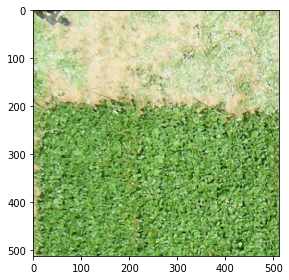

In [ ]:
imshow(train[6]);

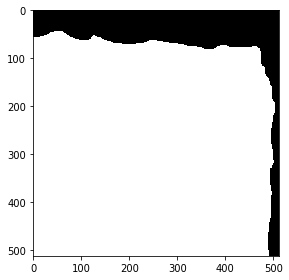

In [ ]:
imshow(train_rot[2]);

### **4.1- Segmentação por limiar**

##### A ideia desta metodologia é encontrar um valor limiar com o qual, a partir dele, são definidas as classes da imagem. Ou seja, para o problema em questão (classificação binária), precisamos encontrar o melhor valor que indique que determinado pixel pertence à classe plantação (1 - branco) ou à classe terra (0 - preto)

###### **Exemplo:** Imagem 2

In [ ]:
img = train[2]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#gray = img
I0_opt1_mask = np.where(gray>150,0,1)
img_rot = train_rot[2]
#img_rot_gray = cv2.cvtColor(img_rot, cv2.COLOR_BGR2GRAY)
img_rot_gray = img_rot
img_rot_gray_mask = np.where(img_rot_gray>0,1,0)

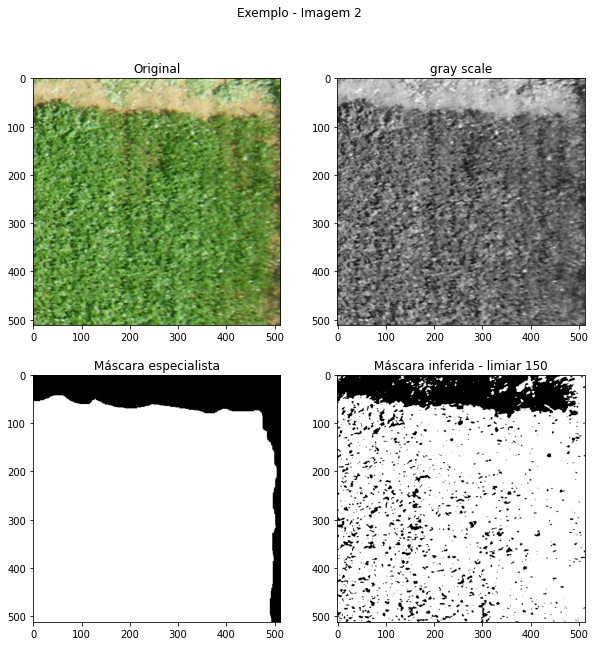

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(10)
fig.suptitle('Exemplo - Imagem 2')
ax1.imshow(img)
ax1.set_title('Original')
ax2.imshow(gray,cmap='gray')
ax2.set_title('gray scale')

ax3.imshow(img_rot_gray_mask,cmap='gray' )
ax3.set_title('Máscara especialista')

ax4.imshow(I0_opt1_mask,cmap='gray')
ax4.set_title('Máscara inferida - limiar 150');




### **Otimização**

##### Podemos criar uma função para determinar o valor ótimo desse limiar:

In [ ]:
def max_f1(gt,gray):

  vec=np.arange(30,220,1)
  x = np.zeros(vec.size)
  max_x = np.array(30)
  max_f1 = np.array(0)

  j=0
  for i in vec:
    x[j] = f1_score(gt.ravel(), np.where(gray > i ,0,1).ravel(), average='macro')  
    if x[j] > max_f1: 
      max_f1 = x[j]
      max_x  = i
    j += 1

  return x , vec , max_x , max_f1


In [ ]:
x, vec, limiar, max_f1 = max_f1(img_rot_gray_mask,gray)

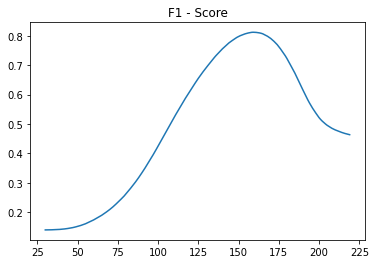

In [ ]:
plt.plot(vec, x)
plt.title('F1 - Score');

In [ ]:
print("O valor máximo de F1-Score:  {:.2f}".format(max_f1) , "é atingido no limiar:", limiar)

O valor máximo de F1-Score:  0.81 é atingido no limiar: 159


#### Extrapolação para todas as imagens

In [ ]:
def max_f1_v2(gt,gray):

  vec=np.arange(30,220,5)
  x = np.zeros(vec.size)
  max_x = np.array(30)
  max_f1 = np.array(0)

  j=0
  for i in vec:
    x[j] = f1_score(gt.ravel(), np.where(gray > i ,0,1).ravel(), average='macro')  
    if x[j] > max_f1: 
      max_f1 = x[j]
      max_x  = i
    j += 1

  return max_x 


def seleciona_img(dados,rotulos):

  # Tratamento de dimensão, pois algumas imagens não tinham rótulos iguais a imagem
  s = 0
  for w in range(0,np.array(dados).shape[0]):
    if dados[s].shape[0] == 512:
      s += 1
  print(s)
  limiarx = np.zeros(s)
  for k in range(0,s):
    img = dados[k]
    img_rot = rotulos[k]
    if img.ndim > 2: 
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
      gray = img
    if img_rot.ndim > 2: 
      img_rot_gray = cv2.cvtColor(img_rot, cv2.COLOR_BGR2GRAY)
    else:
      img_rot_gray = img_rot
    img_rot_gray_mask = np.where(img_rot_gray>0,1,0)
    if rotulos[k].shape[0] == 512 and dados[k].shape[0] == 512:
      print(k)
      limiarx[k] = max_f1_v2(img_rot_gray_mask,gray)
  return np.median(limiarx)   

In [ ]:
limiar_all = seleciona_img(train,train_rot)

24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [ ]:
print("O valor obtido foi de:", limiar_all)

O valor obtido foi de: 162.5


### Avaliando a imagem 2

In [ ]:
f1_all = f1_score(img_rot_gray_mask.ravel(), np.where(gray > limiar_all ,0,1).ravel(), average='macro') 

In [ ]:
print("O valor máximo de F1-Score:  {:.2f}".format(f1_all) , "é atingido no limiar:", limiar_all)

O valor máximo de F1-Score:  0.81 é atingido no limiar: 162.5


#### Outras imagens

In [ ]:
img = train[5]
if img.ndim > 2: 
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
  gray = img

I0_opt1_mask = np.where(gray>limiar_all,0,1)

img_rot = train_rot[5]

if img_rot.ndim > 2: 
  img_rot_gray = cv2.cvtColor(img_rot, cv2.COLOR_BGR2GRAY)
else:
  img_rot_gray = img_rot

img_rot_gray_mask = np.where(img_rot_gray>0,1,0)

f1_score(img_rot_gray_mask.ravel(), np.where(gray > limiar_all ,0,1).ravel(), average='macro') 

0.5067883515081002

### Avaliação no conjunto de teste

In [ ]:
test = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/img/*.png", conserve_memory=True)
test_rot = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/*.png", conserve_memory=True)


In [ ]:
limiar_all = 162.5

# 8 imagens de teste!
f1 = np.zeros(8,dtype=np.float)

for i in range(0,np.size(f1)):
  
  img = test[i]
  if img.ndim > 2: 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  else:
    gray = img

  I0_opt1_mask = np.where(gray>limiar_all,0,1)

  img_rot = test_rot[i]

  if img_rot.ndim > 2: 
    img_rot_gray = cv2.cvtColor(img_rot, cv2.COLOR_BGR2GRAY)
  else:
    img_rot_gray = img_rot

  img_rot_gray_mask = np.where(img_rot_gray>0,1,0)

  f1[i] = f1_score(img_rot_gray_mask.ravel(), np.where(gray > limiar_all ,0,1).ravel(), average='macro') 
  print('F1-Score da image', i, ':', round(f1[i],2))

print('\n O valor médio do F1-Score foi de:', round(np.sum(f1)/np.size(f1),2))



F1-Score da image 0 : 0.49
F1-Score da image 1 : 0.58
F1-Score da image 2 : 0.6
F1-Score da image 3 : 0.54
F1-Score da image 4 : 0.57
F1-Score da image 5 : 0.58
F1-Score da image 6 : 0.59
F1-Score da image 7 : 0.62

 O valor médio do F1-Score foi de: 0.57


### **4.2 - Segmentação end2end deep learning**

In [ ]:
#!pip install git+https://github.com/qubvel/segmentation_models
#!pip install mahotas

#### **4.2.1 - Dados de Treinamento**

In [9]:
input_dir = "/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/"
target_dir = "/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/"
img_size = (512, 512)
num_classes = 2
batch_size = 3

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 24
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_12.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_12.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_13.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_13.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_14.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_14.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_15.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_15.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_17.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_17.png
/content/drive/MyDrive/Doutorado/pesqu

#### **4.2.2 - Dados de Teste**

In [10]:
input_dir = "/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/img/"
target_dir = "/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/"
img_size = (512, 512)
num_classes = 2
batch_size = 3

input_img_paths_t = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths_t = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths_t))

for input_path, target_path in zip(input_img_paths_t[:10], target_img_paths_t[:10]):
    print(input_path, "|", target_path)

Number of samples: 8
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/img/imagem_1.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_1.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/img/imagem_11.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_11.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/img/imagem_16.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_16.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/img/imagem_18.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_18.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/img/imagem_29.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_29.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experi

In [18]:
target_img_paths_t

['/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_1.png',
 '/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_11.png',
 '/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_16.png',
 '/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_18.png',
 '/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_29.png',
 '/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_34.png',
 '/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_40.png',
 '/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_9.png']

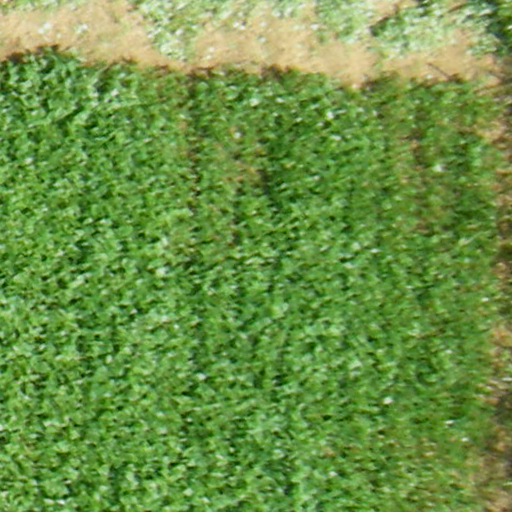

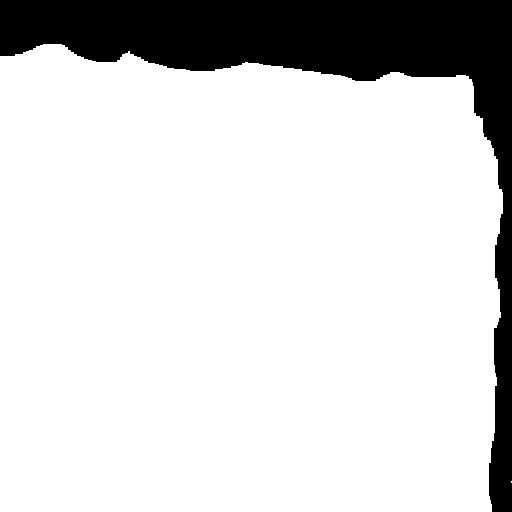

In [44]:



# Display input image 
display(Image(filename=input_img_paths[19], width = 150, height = 150))

# Display mask
display(Image(filename=target_img_paths[19], width = 150, height = 150))

In [97]:


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img.size
            y[j] = np.where(np.expand_dims(img, 2)>0,1,0).astype(np.uint8) 
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [98]:


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [99]:
# Instantiate data Sequences for each split
train_gen = OxfordPets(batch_size, img_size, input_img_paths, target_img_paths)
val_gen = OxfordPets(batch_size, img_size, input_img_paths_t, target_img_paths_t)

In [ ]:

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
#model.compile(optimizer="rmsprop", loss="binary_crossentropy")
model.compile(optimizer="adam", loss="BinaryCrossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 10
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

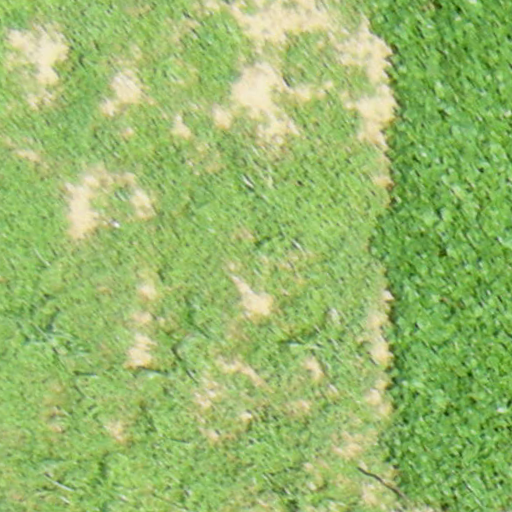

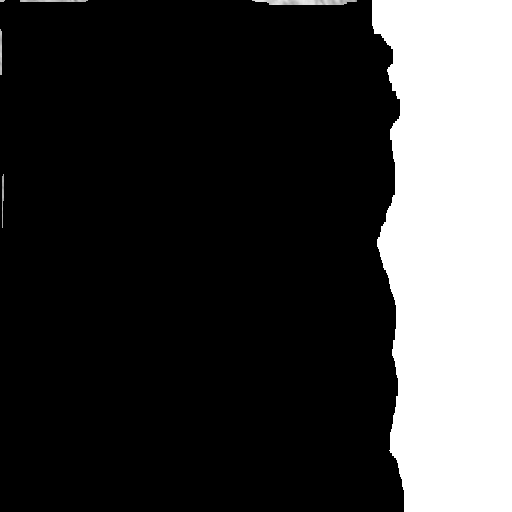

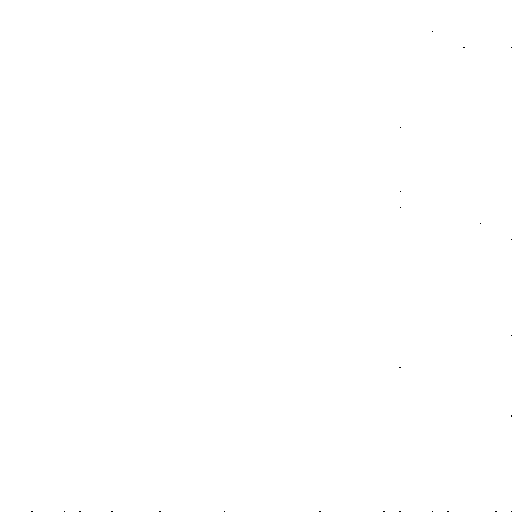

In [81]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, input_img_paths_t, target_img_paths_t)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 1

# Display input image
display(Image(filename=input_img_paths_t[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(target_img_paths_t[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

### **4.3 - Segmentação end2end deep learning com Data Augmentation**

In [59]:
x_train_dir = "/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/"
y_train_dir = "/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/"

x_valid_dir = "/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/img/"
y_valid_dir = "/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/"

In [27]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['black', 'white']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

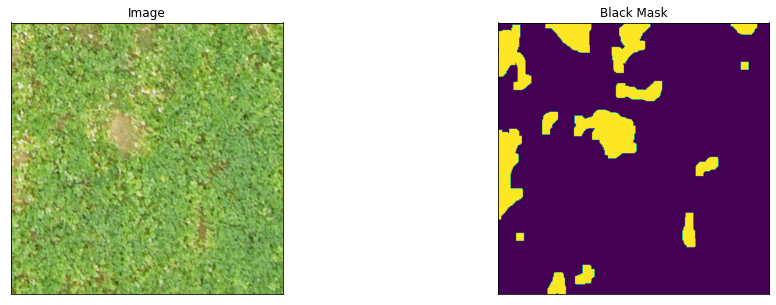

In [108]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['black'])

image, mask = dataset[2] # get some sample
visualize(
    image=image, 
    black_mask=mask[..., 0].squeeze(),

)

In [31]:
#Augmentations
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [32]:
import albumentations as A

In [42]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        A.RandomCrop(height=512, width=512, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(512, 512)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)


/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

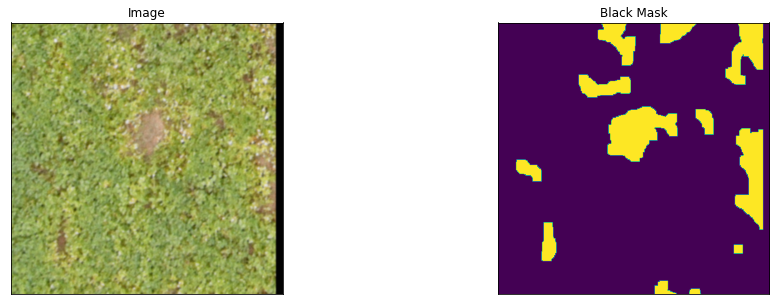

In [90]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['black'], augmentation=get_training_augmentation())

image, mask = dataset[2] # get some sample
visualize(
    image=image, 
    black_mask=mask[..., 0].squeeze(),
    

)

In [91]:
#Segmentation model trainin
import segmentation_models as sm
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [ ]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

# Referências
### https://github.com/qubvel/segmentation_models
### https://github.com/ProfBressan/FeatureExtraction

### Ponti, M. et al. "Precision Agriculture: using low-cost systems to acquire low-altitude images". IEEE Computer Graphics and Applications, 2016.
